In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

σ = torch.sigmoid

In [3]:
import sys
sys.path.append("../src/")

from metrics import (
    find_split_indices,
    calculate_metrics,
    accuracy
)

from losses import (
    DiceLoss,
    ComboLoss
)

from utils import (
    proba2class,
    create_diag,
    predict_1d
)

from datasets import Dataset2D

from UNet import UNet

In [4]:
mps_is_ok = torch.backends.mps.is_built() and torch.backends.mps.is_available()
device = torch.device('mps' if mps_is_ok else 'cpu')
print(device)

mps


In [5]:
# device = torch.device("mps")
# device = torch.device("cpu")

# Dataset

In [6]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(
    filename,
    # nrows=int(2**14)  # debug
)

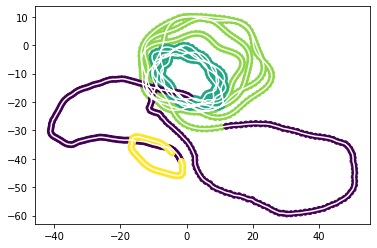

In [7]:
df_draw = df[:1_000]
plt.plot(df_draw.x, df_draw.y, "w")
plt.scatter(df_draw.x, df_draw.y, c=df_draw.period)

In [8]:
i_train = len(df) * 8 // 10
WINDOW_SIZE = 512
WINDOW_STEP = WINDOW_SIZE // 2
dataset_train = Dataset2D(
    df[:i_train],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP,
    train=True
)

dataset_test = Dataset2D(
    df[i_train:],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP
)

In [9]:
len(dataset_train)

474

In [10]:
x, y = dataset_train[2]

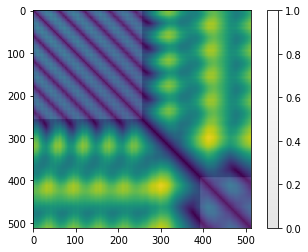

In [11]:
plt.imshow(x[0], interpolation="none")
plt.imshow(y[0], alpha=0.1, cmap="Greys_r")
plt.colorbar()

In [12]:
batch_size = 16  # len(dataset_train) // 100
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model

In [13]:
model = UNet(1, 1, hidden_channels=4)
model.eval;

In [14]:
summary(model, (1, WINDOW_SIZE, WINDOW_SIZE), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 512, 512]              36
       BatchNorm2d-2          [-1, 4, 512, 512]               8
              ReLU-3          [-1, 4, 512, 512]               0
            Conv2d-4          [-1, 4, 512, 512]             144
       BatchNorm2d-5          [-1, 4, 512, 512]               8
              ReLU-6          [-1, 4, 512, 512]               0
        DoubleConv-7          [-1, 4, 512, 512]               0
         MaxPool2d-8          [-1, 4, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]             288
      BatchNorm2d-10          [-1, 8, 256, 256]              16
             ReLU-11          [-1, 8, 256, 256]               0
           Conv2d-12          [-1, 8, 256, 256]             576
      BatchNorm2d-13          [-1, 8, 256, 256]              16
             ReLU-14          [-1, 8, 2

In [15]:
x = torch.rand(batch_size, 1, 512, 512).to(device)
model = model.to(device);

In [16]:
%%timeit
y = model(x)

63.8 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
calculate_loss = ComboLoss(α=0.1, bce_weight=0.5)

In [18]:
model = UNet(1, 1, hidden_channels=4)
# device = torch.device("mps")
# device = torch.device("cpu")
model = model.to(device)

In [19]:
x, y = dataset_test[10]
x = x.to(device)
y = y.to(device)

In [20]:
y_pred = model(x.unsqueeze(0))

In [21]:
calculate_loss = nn.BCEWithLogitsLoss()

In [22]:
calculate_loss(y_pred, y.unsqueeze(0))

/Users/andrey/Work/HPL/projects/rheeda/nn/.venv/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor(0.7367, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Train

In [23]:
def train_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    model.train()

    for X, Y in tqdm(dataloader):
        
        X = X.to(device)
        Y = Y.to(device)  
        
        optimizer.zero_grad()
        
        Y_pred = model.forward(X)
        
        assert not torch.isnan(Y_pred).any()

        loss = calculate_loss(Y_pred, Y)
        
        assert not np.isnan(loss.item())
            
        loss.backward()
        
        optimizer.step()

        score = accuracy(Y_pred, Y)
        
        loss_sum += loss.item()
        score_sum += score
        
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
        
    return loss, score

In [24]:
def test_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    metrics_all = []
    n_diffs = []
    
    with torch.no_grad():

        model.eval()
        
        for X, y_true in tqdm(dataloader):
            
            X = X.to(device)
            y_true = y_true.to(device)  
            y_pred = model(X)
            
            loss = calculate_loss(y_pred, y_true)
            
            score = accuracy(y_pred, y_true)
            
            loss_sum += loss.item()
            score_sum += score
                
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
        
    return loss, score

In [25]:
def train_epoch(model, optimizer):
    
    objectives = {}
    
    # Train
    
    loss, score = train_model(
        model,
        train_dataloader
    )
        
    objectives["loss_train"] = loss
    objectives["score_train"] = score
    
    # Test

    loss, score = test_model(
        model,
        test_dataloader
    )
    objectives["loss_test"] = loss
    objectives["score_test"] = score

    return objectives

# Main

In [26]:
# device = torch.device("cpu")
# device = torch.device("mps")

In [27]:
model = UNet(1, 1, hidden_channels=4)
model = model.to(device)

rows_progress = []
score_test_best = 0.

In [28]:
# calculate_loss = DiceLoss()
# calculate_loss = nn.BCEWithLogitsLoss()

calculate_loss = ComboLoss(α=0.1)

In [29]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-2
)

In [30]:
# pred, true = train_model(model, train_dataloader)

In [31]:
filename_model_save = "../models/unet-latest.st"

n_epochs = 10

with trange(n_epochs) as t:
    for epoch in t:
        
        objectives = train_epoch(model, optimizer)
            
        rows_progress.append(objectives)
        
        score_test = objectives["score_test"]
        if score_test > score_test_best:
            score_test_best = score_test
            torch.save(model.state_dict(), filename_model_save)

        t.set_postfix(
            train=objectives["score_train"],
            test=score_test,
            best=score_test_best
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [32]:
df_progress = pd.DataFrame(rows_progress)

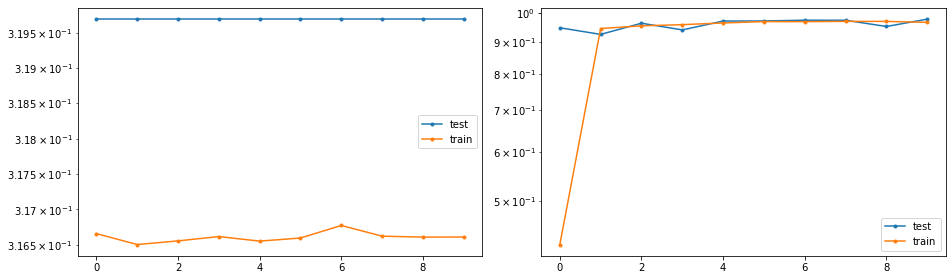

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))

for i, key in enumerate(["loss", "score"]):

    ax = axes[i]
    plt.sca(ax)

    for t in "test", "train":
        plt.plot(df_progress[f"{key}_{t}"], ".-", label=t)

    plt.legend()
    plt.yscale("log")

plt.tight_layout()

# Best

In [34]:
# model.load_state_dict(torch.load(filename_model_save))
# model.eval();

In [35]:
model = torch.jit.load('../models/unet-latest.pt')
model = model.to(device)
model.eval();

In [36]:
len(dataset_test)

117

In [37]:
x, y = dataset_test[108]
x = x.to(device)
y = y.to(device)

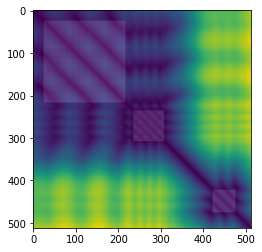

In [38]:
plt.imshow(x[0].cpu())
plt.imshow(y[0].cpu(), alpha=0.1, cmap="Greys_r")

In [39]:
with torch.no_grad():
    y_pred = model(x.unsqueeze(0))
    
output = σ(y_pred.squeeze()).cpu()

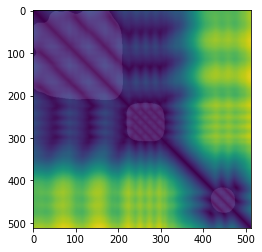

In [40]:
plt.imshow(x[0].cpu())
plt.imshow(output.cpu() > 0.5, alpha=0.1, cmap="Greys_r")

In [41]:
A = (output + output.T) / 2

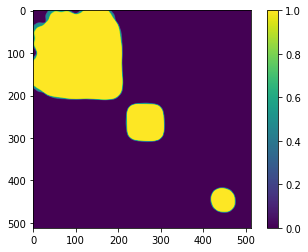

In [42]:
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()

In [43]:
pred = predict_1d(A)

In [44]:
true = predict_1d(y[0].cpu())

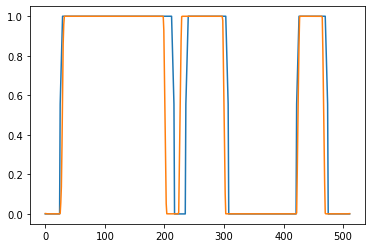

In [45]:
plt.plot(true)
plt.plot(pred)

# Metrics

In [46]:
scores_1d = []
scores_2d = []

for x, y in tqdm(dataset_test):
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze()
    true = y.cpu().squeeze()
    
    scores_2d.append(accuracy(pred, true))    
        
    pred = predict_1d(pred.cpu())
    true = predict_1d(y.cpu().squeeze())
        
    scores_1d.append(accuracy(pred, true))

  0%|          | 0/117 [00:00<?, ?it/s]

In [47]:
np.mean(scores_1d)

0.9406383547008547

In [48]:
np.mean(scores_2d)

0.9811417017227564

In [84]:
df_metrics = []

for x, y in tqdm(dataset_test):
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        pred = σ(model(x.unsqueeze(0))).squeeze()
    pred = predict_1d(pred.cpu())
    true = predict_1d(y.cpu().squeeze())
    
    row = calculate_metrics(
        proba2class(pred),
        proba2class(true),
    )
    
    df_metrics.append(row)
        
df_metrics = pd.concat(df_metrics)

  0%|          | 0/117 [00:00<?, ?it/s]

In [85]:
df_metrics.dropna(inplace=True)

In [86]:
df_metrics.describe().round(2)

,iou,offset,onset,intersection,union
count,202.00,202.00,202.00,202.00,202.00
mean,0.88,-5.72,5.16,136.69,150.35
std,0.09,6.54,6.20,80.57,82.76
min,0.34,-28.00,-20.00,11.00,32.00
25%,0.85,-9.00,2.00,77.00,86.00
50%,0.91,-6.00,6.00,117.50,129.50
75%,0.94,-3.00,8.00,177.75,192.00
max,1.00,20.00,31.00,420.00,443.00


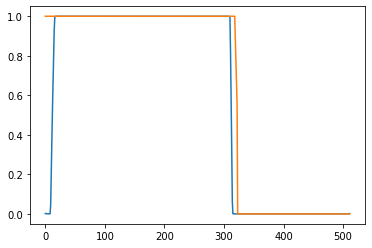

In [87]:
plt.plot(pred)
plt.plot(true)

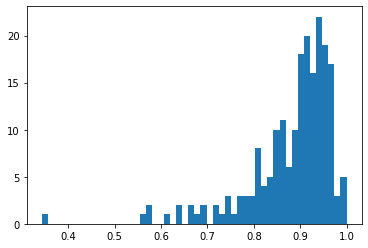

In [88]:
plt.hist(df_metrics.iou, bins=50);

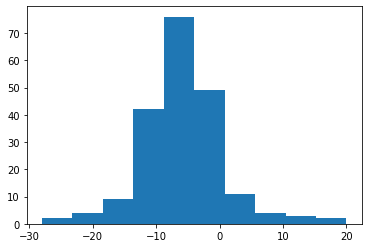

In [89]:
plt.hist(df_metrics.offset);

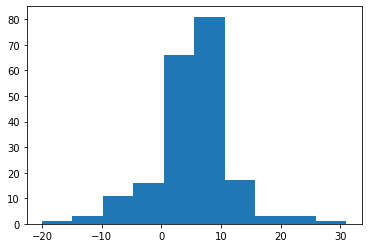

In [90]:
plt.hist(df_metrics.onset);

(-22.55, 33.55, -30.4, 22.4)

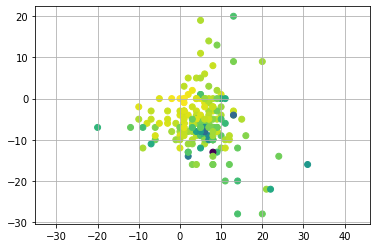

In [91]:
plt.scatter(
    df_metrics.onset,
    df_metrics.offset,
    c=df_metrics.iou
)

plt.grid()
plt.axis("equal")